# CS450.4 Final Project - adhavle - Classifying Partisan Bias in News Articles
- I am attempting to replicate some of the methods used in [Classifying Partisan Bias in News Articles:
 Leveraging an Understanding of Political Language
 and Article Structure](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/final-reports/final-report-169502805.pdf), which uses a dataset from a competition on detecting hyperpartisan and fake news.
- Dataset location [Data for PAN at SemEval 2019 Task 4: Hyperpartisan News Detection](https://zenodo.org/records/1489920)
- Also see [Hyperpartisan News Detection 2019](https://pan.webis.de/semeval19/semeval19-web/#data) and [SemEval-2019 Task 4: Hyperpartisan News Detection](https://aclanthology.org/S19-2145.pdf)


In [71]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#### Comments
 - The dataset is downloaded to, and prepared in, the `dataset` dir
 - `articles-validation-bypublisher-20181122-html-escaped.xml` contains a list of 150,000 news articles (sourced online)
 - `ground-truth-validation-bypublisher-20181122.xml` contains the targets for these articles
 - Targets are `left`, `left-center`, `least`, `right-center`, `right`

In [2]:
dataset_dir = os.path.join(os.getcwd(), "dataset")
training_data_file = os.path.join(dataset_dir, "articles-validation-bypublisher-20181122-html-escaped.xml")
target_data_file = os.path.join(dataset_dir, "ground-truth-validation-bypublisher-20181122.xml")

In [3]:
datadf = pd.read_xml(path_or_buffer = training_data_file)
targetdf = pd.read_xml(path_or_buffer = target_data_file)
df = pd.concat([datadf, targetdf], axis = 1)
df.columns = [
    'id',
    'published-at',
    'title',
    'article',
    'id2',
    'hyperpartisan',
    'bias',
    'url',
    'labeled-by'
]

#### Comments
- Training data and targets are now in a single dataframe.
- There should be 150,000 articles
- The `id` field from training and target sets should match
- No record should have an empty `article` or `bias` field

In [4]:
# run some test cases to ensure the data is good
if len(df) == 150_000:
    print(f"PASS: dataframe has {len(df)} records as expected")
else:
    print(f"FAIL: dataframe has {len(df)} records - expected 150,000")

def validate_column_does_not_have_null_values(column_name):
    if df[column_name].isnull().sum() == 0:
        print(f"PASS: no null values detected for column '{column_name}'")
    else:
        print(f"FAIL: {df[column_name].isnull().sum()} null values for column '{column_name}' not expected")

validate_column_does_not_have_null_values("id")
validate_column_does_not_have_null_values("id2")
validate_column_does_not_have_null_values("article")
validate_column_does_not_have_null_values("bias")

id_matches = df['id'] == df['id2']
n_not_matched = id_matches.value_counts().get(False, 0)
n_matched = id_matches.value_counts().get(True, 0)
if n_matched == 150_000 and n_not_matched == 0:
    print(f"PASS: all article IDs from training file and target file matched (id == id2 for all records)")
else:
    print(f"FAIL: {n_matched} article IDs from training file matched, BUT {n_not_matched} article IDs did not match")

PASS: dataframe has 150000 records as expected
PASS: no null values detected for column 'id'
PASS: no null values detected for column 'id2'
PASS: no null values detected for column 'article'
PASS: no null values detected for column 'bias'
PASS: all article IDs from training file and target file matched (id == id2 for all records)


#### Comments
The dataset is loaded along with target values. The `id2` column has served its purpose in validating the join with the target data and can be dropped going forward.

In [5]:
df = df.drop('id2', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             150000 non-null  int64 
 1   published-at   100492 non-null  object
 2   title          137723 non-null  object
 3   article        150000 non-null  object
 4   hyperpartisan  150000 non-null  bool  
 5   bias           150000 non-null  object
 6   url            150000 non-null  object
 7   labeled-by     150000 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 8.2+ MB


In [6]:
df.head()

,id,published-at,title,article,hyperpartisan,bias,url,labeled-by
0,17,2004-07-29,SAN FRANCISCO / Head of Juvenile Probation Dep...,"<p>Chief juvenile probation officer <a href=""/...",False,left-center,http://sfgate.com/politics/article/SAN-FRANCIS...,publisher
1,23,2017-04-20,"University leaders ban pro-life flag display, ...",<p>Pro-life students at Wilfrid Laurier Univer...,True,right,https://thecollegefix.com/post/32204/,publisher
2,29,2017-09-12,"DONALD TRUMP, GET YOUR TINY PIGGY PERVERT HAND...",<p>Time for Hillary Clinton to go back to Beng...,True,left,https://wonkette.com/622815/donald-trump-get-y...,publisher
3,32,2016-06-05,DIRTY: Hillary Clinton Implies Trump is a Nazi...,<p></p> \n<p>Do you want to know why violent u...,True,right,http://thegatewaypundit.com/2016/06/dirty-croo...,publisher
4,37,2015-01-12,A Bipartisan Work Plan,<p>American workers continue to struggle with ...,False,right-center,https://cfr.org/report/bipartisan-work-plan,publisher


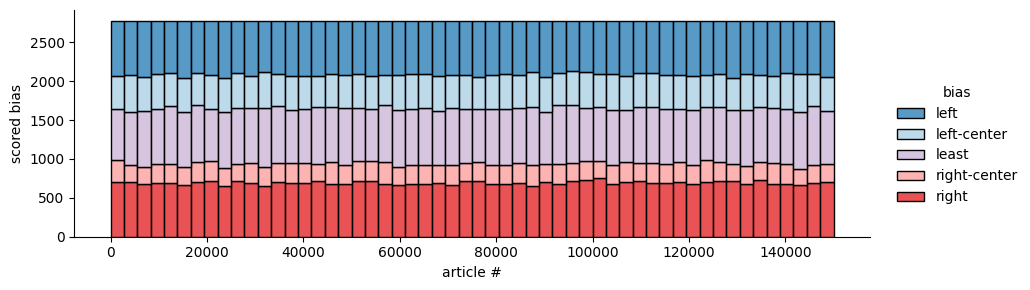

In [7]:
base_palette = sns.color_palette("Paired")
bias_palette = [
    base_palette[1], # blue (left)
    base_palette[0], # light blue (left-center)
    base_palette[8], # purple (least)
    base_palette[4], # light red (right-center)
    base_palette[5], # red (right)
]

data_distribution_chart = sns.displot(
    data = df,
    x = df.index,
    hue = "bias",
    multiple = "stack",
    height = 3,
    aspect = 3,
    hue_order = ['left', 'left-center', 'least', 'right-center', 'right'],
    palette = bias_palette)

data_distribution_chart.set_xlabels("article #")
data_distribution_chart.set_ylabels("scored bias")
plt.show()

#### Comments
 - The 5 categories are distributed roughly evenly across the dataset
 - The top (blue) and bottom (red) regions represent the hyperpartisan articles
 - Middle bands (light blue, light red, purple) are not considered hyperpartisan

In [68]:
#P2 - find a better way of doing this

hy_df = df.groupby(['hyperpartisan', 'bias'])['bias'].count()
h, b, c = [], [], []
for k,v in hy_df.items():
    h.append(k[0])
    b.append(k[1])
    c.append(v)

pd.options.display.max_rows = 5
display(pd.DataFrame({"hyperpartisan": h, "bias": b, "count": c}))

,hyperpartisan,bias,count
0,False,least,38296
1,False,left-center,23473
2,False,right-center,13231
3,True,left,37500
4,True,right,37500


### Comments
 - As expected, the hyperpartisan label corresponds to categories `left` and `right`
 - I will focus on predicting `bias` and ignore the `hyperpartisan` column since it can be inferred from `bias`

#### Determining the feature size for training
 - The articles must be vectorized for model training. The plan is to use TF-IDF
 - Optimum values for max_features (and other params) can be found using GridSearchCV, with Logistic Regression
 - I'll assume the optimum choice for Logistic Regression is good enough for other classifiers, and use that option going forward
 - Will use scikit's default stopwords list, even though it has [known issues](https://aclanthology.org/W18-2502/)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df, df['bias'], test_size=0.2, random_state=42, stratify=df['bias'])

pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words='english')),
    ("classifier", LogisticRegression(max_iter=200, random_state=42))
])

parameters = {
#    "vectorizer__lowercase": [True, False],
    "vectorizer__max_features": [1000, 1500, 2000, 2500],
    "vectorizer__min_df": [5],
    "vectorizer__max_df": [0.7],
#    "vectorizer__min_df": [5, 20, 50],
#    "vectorizer__max_df": [0.6, 0.7, 0.8],
#    "classifier__solver": ['lbfgs', 'sag', 'newton-cholesky'],
#    "classifier__": [],
#    "classifier__": [],
}

search = GridSearchCV(pipeline, parameters, n_jobs=-1)
search.fit(x_train, y_train)
print("Best parameter (CV score = %0.3f):" % search.best_score_)
print(search.best_params_)

In [8]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english', 
    max_features=5000,
    min_df=5,
    max_df=0.7)


seconds_start_time = time.time() # replace with timer.start, and timer.end methods. 

bag_of_words = vectorizer.fit_transform(df['article'])

print(f"vectorizer.fit_transform took {time.time() - seconds_start_time} seconds")

bag_of_words_df = pd.DataFrame(
    bag_of_words.toarray(), 
    columns=vectorizer.get_feature_names_out())

bag_of_words_df.head()

vectorizer.fit_transform took 67.45028710365295 seconds


,00,000,01,02,03,04,05,06,07,08,...,younger,youth,youtube,yuan,zero,zimbabwe,zionist,zone,zones,zuma
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.105243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.049117,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.050786,0.000000,0.0,0.0,0.0,0.0,0.04286,0.042846,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.031106,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(bag_of_words_df, 
                                                    df['bias'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df['bias'])

In [10]:
# https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
# https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406
# https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/
model = LogisticRegression(max_iter=1000)

seconds_start_time = time.time() # replace with timer.start, and timer.end methods. 
model.fit(x_train, y_train)
print(f"model.fit took {time.time() - seconds_start_time} seconds")

model.score(x_test, y_test)

model.fit took 140.3797688484192 seconds


0.8214

In [11]:
for i in range(100):
    p = (model.predict(x_test.iloc[[i]]))[0]
    prb = model.predict_proba(x_test.iloc[[i]])
    a = ((y_test.iloc[[i]]).values)[0]
    matched = "matched"
    if p != a:
        matched = "NOT MATCHED"
    # print(f"{i} - {prb} predicted {p} - actual {a} - {matched}")

In [12]:

x_train.head()

,00,000,01,02,03,04,05,06,07,08,...,younger,youth,youtube,yuan,zero,zimbabwe,zionist,zone,zones,zuma
44788,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.035492,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15687,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57894,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.056923,...,0.0,0.0,0.066595,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123353,0.0,0.0,0.019602,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.022681,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130296,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
